In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load dataset
df_os = pd.read_csv('datasets/openstack_metrics.csv') # the OS df
df_qt = pd.read_csv('datasets/qt_metrics.csv') # the QT df

bugrows_OS = len(df_os[df_os["bugcount"]==1])
bugrows_QT = len(df_os[df_os["bugcount"]==1])



print("Rows in    OSdf:", bugrows_OS ,"/",len(df_os),"=", bugrows_OS/len(df_os), "   QTdf:", bugrows_QT ,"/", len(df_qt), "=",bugrows_QT/len(df_qt) )


Rows in    OSdf: 1479 / 26855 = 0.05507354310184323    QTdf: 1479 / 32155 = 0.045995957082879804


In [15]:
df_os[df_os["bugcount"]>=0]

,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,ent,...,oexp,arexp,rrexp,orexp,asexp,rsexp,osexp,asawr,rsawr,osawr
9,001407b969bc12d48bd7f10960f84f519bb19111,1278972225,1.0,NaN,22435,0,104,22,5,0.816511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,001d36c97eac77410f7dd32290d2142abfb19fa0,1392721937,0.0,NaN,12,6,2,2,1,0.309543,...,2599.0,834.0,1211.0,1873.0,1087.0,1361.0,2241.0,0.147545,0.184703,0.304041
19,002ce47d757461546c24a4e8ba909fca42c38997,1405937783,2.0,NaN,304,16,12,2,1,0.803639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,002d711fb7f16a6d5c7977e82e30837287b553b8,1322491078,0.0,NaN,272,276,43,12,1,0.931290,...,231.0,83.0,184.0,231.0,16.0,88.0,88.0,0.173469,0.908163,0.908163
23,0043044f2e8ee3de8a9995bdbf51aad77f1a3fa9,1373357890,3.0,NaN,580,283,8,5,1,0.849502,...,687.0,5.0,662.0,664.0,2.0,42.0,43.0,0.060000,0.860000,0.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26814,ffa11a64706e898ba3ae45f84920d632b5947add,1380332296,1.0,NaN,11,6,3,2,1,0.977036,...,1631.0,148.0,1407.0,1489.0,99.0,135.0,194.0,0.250627,0.340852,0.488722
26835,ffcf3431982a591041d642651f778b53e6db5735,1362091722,1.0,NaN,430,174,12,8,2,0.807404,...,1195.0,334.0,863.0,939.0,241.0,562.0,575.0,0.342291,0.796322,0.814710
26841,ffdfd3368db157f2c178dd319a28b00c505b2da1,1404809564,2.0,NaN,144,15,12,9,1,0.551982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26847,ffefe18334a9456250e1b6ff88b7b47fb366f374,1408818777,1.0,NaN,805,134,26,9,1,0.812641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# I will use QT df for mainly training and evaluate the model completely with OS DF

input_df = df_qt[df_qt["bugcount"]>=0]
X = input_df.drop('bugcount', axis=1).drop('commit_id', axis=1) #drop all rows without bugcount (Those will be useless for training)
y = (input_df['bugcount'] >= 1).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [97]:
# the 3 classifiers I will use to compare:

classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": BaggingClassifier(n_estimators=10, random_state=42)
}



In [106]:
# Training and evaluation

results = {}

for idx, (name, clf) in enumerate(classifiers.items()):
    
    # Create pipeline
    pipeline = Pipeline([
        ('classifier', clf)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred, zero_division=0),
        'recall' : recall_score(y_test, y_pred, zero_division=0),
        'model': pipeline,
        'f1': f1_score(y_test, y_pred),
        'probas': y_proba
    }
    


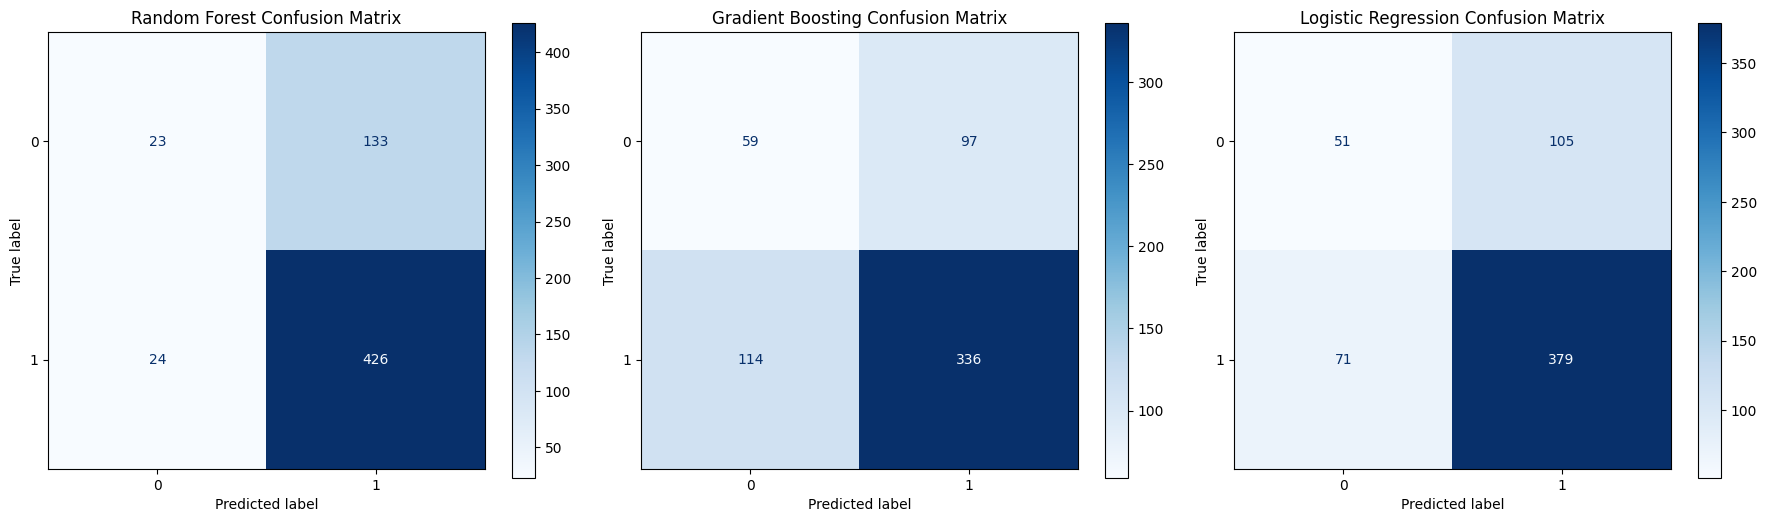

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, res) in enumerate(results.items()):
  # Plot confusion matrix
  ConfusionMatrixDisplay.from_estimator(res['model'], X_test, y_test,  ax=ax[idx], cmap='Blues')
  ax[idx].set_title(f'{name} Confusion Matrix')
  
plt.tight_layout()
plt.show()

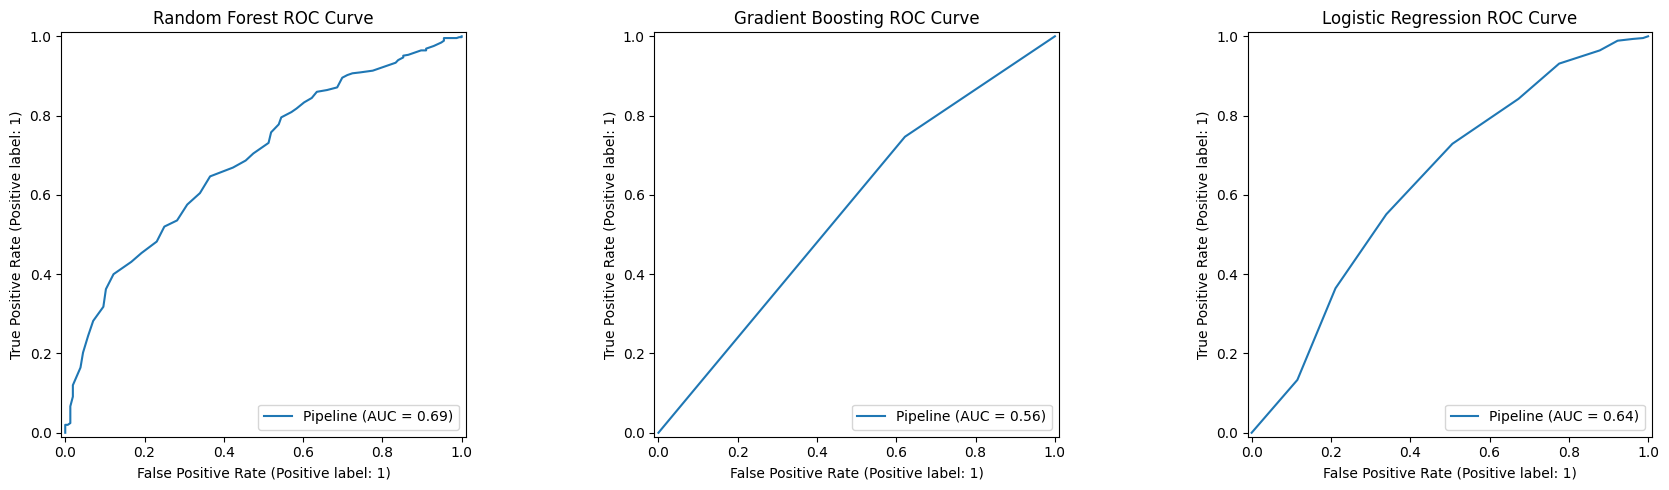

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, res) in enumerate(results.items()):
  # Plot confusion matrix
  RocCurveDisplay.from_estimator(res['model'], X_test, y_test,  ax=ax[idx])
  ax[idx].set_title(f'{name} ROC Curve')
  
plt.tight_layout()
plt.show()

In [107]:
# Print metrics
print("Model Performance:")
for name, res in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {res['accuracy']:.3f}")
    print(f"  Precision: {res['precision']:.3f}")
    print(f"  Recall: {res['recall']:.3f}")
    print(f"  F1-Score: {res['f1']:.3f}\n")

Model Performance:
Random Forest:
  Accuracy: 0.741
  Precision: 0.762
  Recall: 0.947
  F1-Score: 0.844

Gradient Boosting:
  Accuracy: 0.652
  Precision: 0.776
  Recall: 0.747
  F1-Score: 0.761

Logistic Regression:
  Accuracy: 0.710
  Precision: 0.783
  Recall: 0.842
  F1-Score: 0.812

